               temp         atemp           hum     windspeed           cnt
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000
mean       0.496987      0.475775      0.627229      0.190098    189.463088
std        0.192556      0.171850      0.192930      0.122340    181.387599
min        0.020000      0.000000      0.000000      0.000000      1.000000
25%        0.340000      0.333300      0.480000      0.104500     40.000000
50%        0.500000      0.484800      0.630000      0.194000    142.000000
75%        0.660000      0.621200      0.780000      0.253700    281.000000
max        1.000000      1.000000      1.000000      0.850700    977.000000


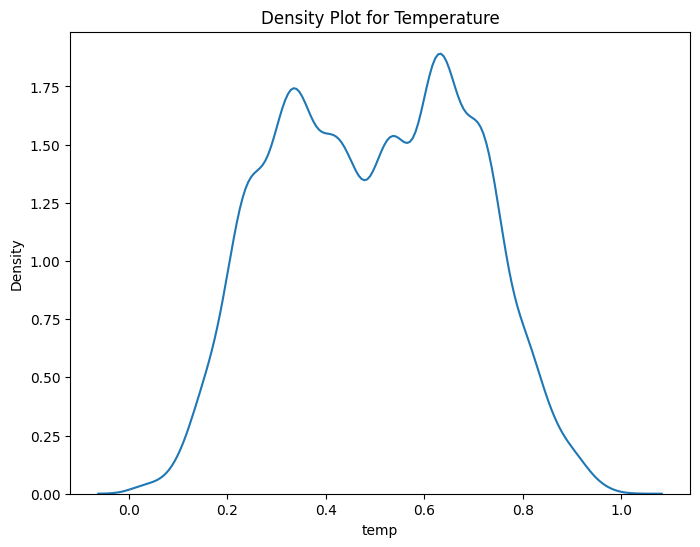

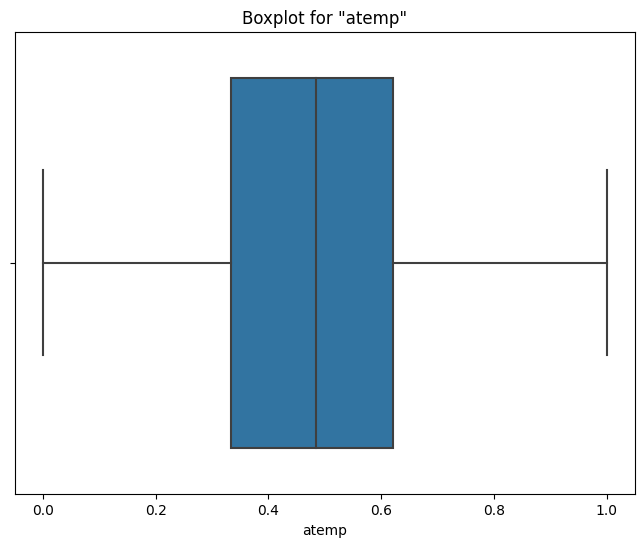

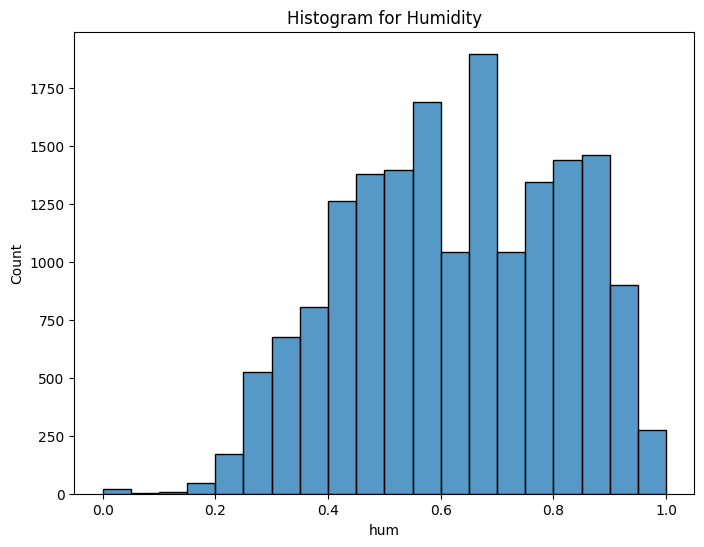

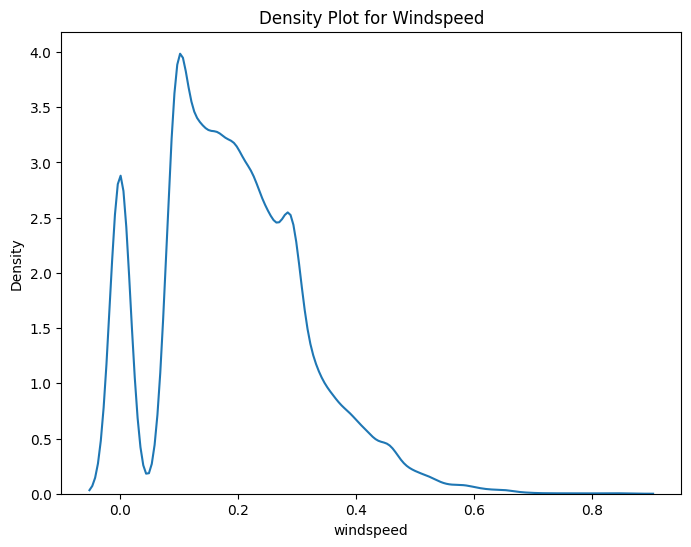

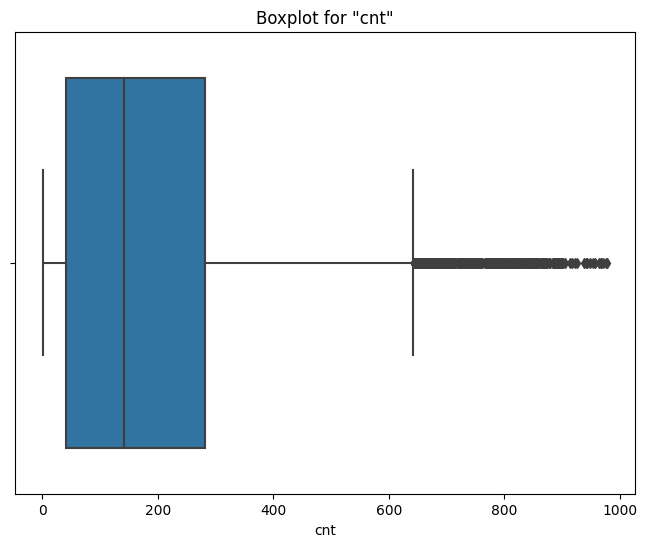

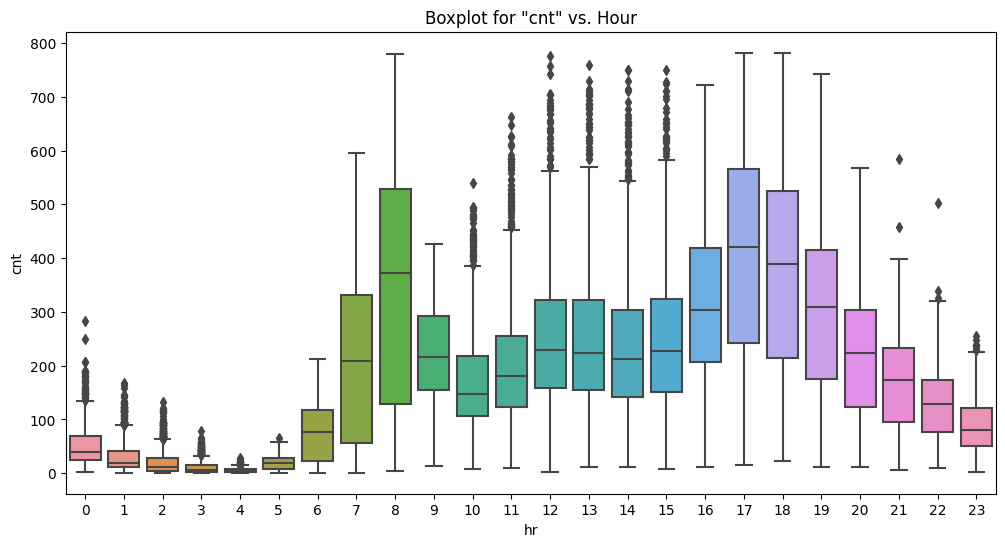

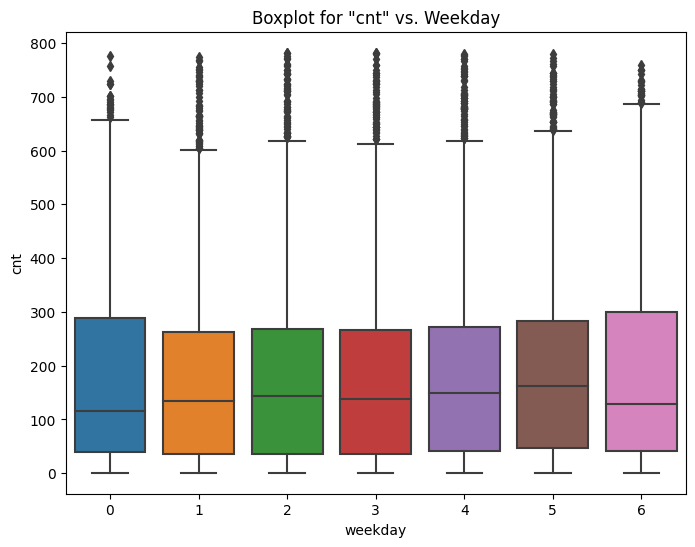

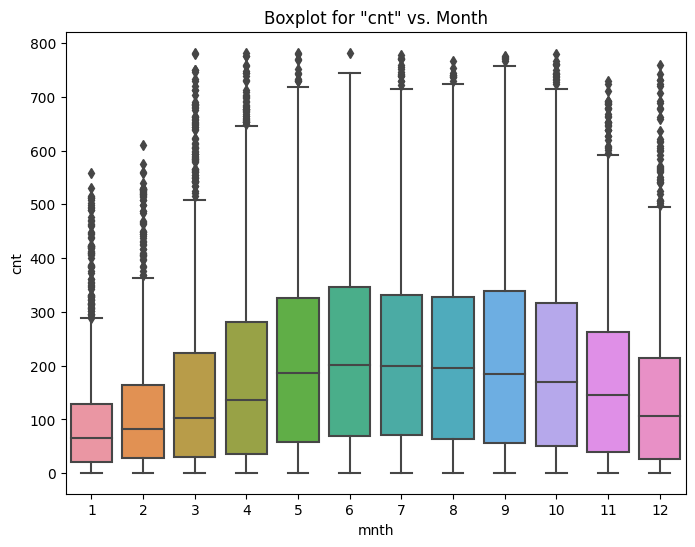

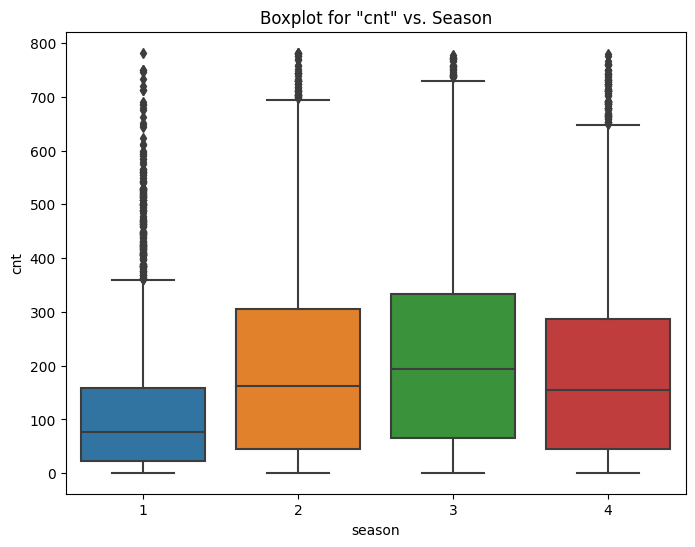

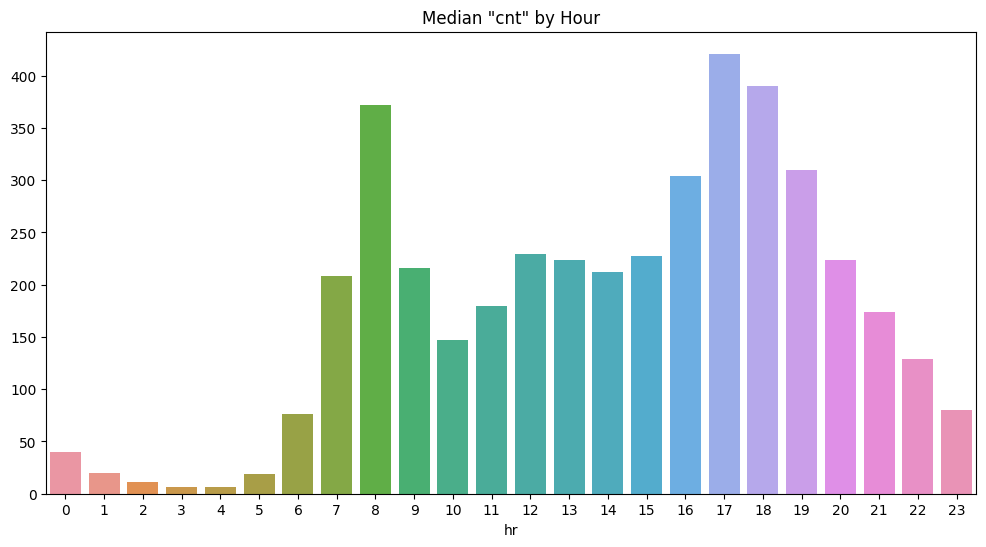

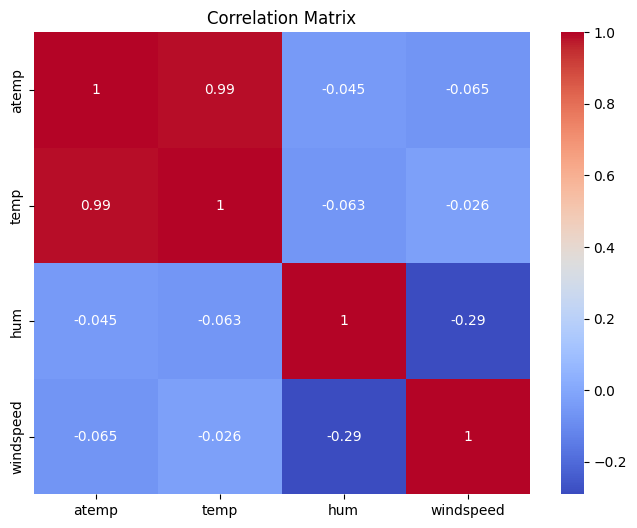

R-squared on the train set: 0.6413745069450464
R-squared on the test set: 0.639860051749827


<ipython-input-2-4bf8c73410c0>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp2['mnth'].replace([5, 6, 7, 8, 9, 10], 5, inplace=True)
<ipython-input-2-4bf8c73410c0>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp2['hr'] = inp2['hr'].map(hr_mapping)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Step 1: Load the data file
data = pd.read_csv(r"/Dataset_Bike (1).csv")

# Step 2: Check for null values and drop records with NAs
data.dropna(inplace=True)

# Step 3: Sanity checks
data = data[data['registered'] + data['casual'] == data['cnt']]
data = data[data['mnth'].between(1, 12)]
data = data[data['hr'].between(0, 23)]
inp1 = data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Step 5: Univariate analysis
numerical_fields = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
print(inp1[numerical_fields].describe())

plt.figure(figsize=(8, 6))
sns.kdeplot(data=inp1, x='temp')
plt.title('Density Plot for Temperature')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=inp1, x='atemp')
plt.title('Boxplot for "atemp"')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=inp1, x='hum', bins=20)
plt.title('Histogram for Humidity')
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(data=inp1, x='windspeed')
plt.title('Density Plot for Windspeed')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=inp1, x='cnt')
plt.title('Boxplot for "cnt"')
plt.show()

# Step 6: Outlier treatment
percentiles = [10, 25, 50, 75, 90, 95, 99]
cutoff_percentile = 99
cutoff_value = np.percentile(inp1['cnt'], cutoff_percentile)
inp2 = inp1[inp1['cnt'] <= cutoff_value]

# Step 7: Bivariate analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=inp2, x='hr', y='cnt')
plt.title('Boxplot for "cnt" vs. Hour')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=inp2, x='weekday', y='cnt')
plt.title('Boxplot for "cnt" vs. Weekday')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=inp2, x='mnth', y='cnt')
plt.title('Boxplot for "cnt" vs. Month')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=inp2, x='season', y='cnt')
plt.title('Boxplot for "cnt" vs. Season')
plt.show()

plt.figure(figsize=(12, 6))
hour_median = inp2.groupby('hr')['cnt'].median()
sns.barplot(x=hour_median.index, y=hour_median.values)
plt.title('Median "cnt" by Hour')
plt.show()

plt.figure(figsize=(8, 6))
corr_matrix = inp2[['atemp', 'temp', 'hum', 'windspeed']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Step 8: Data preprocessing
inp2['mnth'].replace([5, 6, 7, 8, 9, 10], 5, inplace=True)
mnth_dummies = pd.get_dummies(inp2['mnth'], prefix='mnth')
hr_mapping = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12,
              13: 13, 14: 13, 15: 13, 16: 13, 17: 13, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}
inp2['hr'] = inp2['hr'].map(hr_mapping)
hr_dummies = pd.get_dummies(inp2['hr'], prefix='hr')
season_dummies = pd.get_dummies(inp2['season'], prefix='season')
weathersit_dummies = pd.get_dummies(inp2['weathersit'], prefix='weathersit')
weekday_dummies = pd.get_dummies(inp2['weekday'], prefix='weekday')

inp3 = pd.concat([inp2, mnth_dummies, hr_dummies, season_dummies, weathersit_dummies, weekday_dummies], axis=1)
inp3.drop(['mnth', 'hr', 'season', 'weathersit', 'weekday'], axis=1, inplace=True)

# Step 9: Train-test split
X = inp3.drop('cnt', axis=1)
y = inp3['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 10: Model building
model = LinearRegression()
model.fit(X_train, y_train)

# Step 11: Model evaluation
train_predictions = model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)
print('R-squared on the train set:', train_r2)

test_predictions = model.predict(X_test)
test_r2 = r2_score(y_test, test_predictions)
print('R-squared on the test set:', test_r2)